# RAU2:RAD4 co-culture
Results from analysis of the co-culture carrying CA and SAA/RA modules.
Consiting of constructs RAU2 (k12 derived), and RAD4 (k12 derived).

This notebook contains key numbers from the experimental data, static steady-state analysis of relative community member abundance and theoretical max rosmarinic acid (RA) production rate, dynamic simulation and time-course growth and production profiles, and comparison of inoculation ratio and substrate composition.

## Loading and preparing models

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel

# load all models into reframed
RAU2 = load_cbmodel("GEMs/RAU2.xml", flavor="bigg")
RAD4 = load_cbmodel("GEMs/RAD4.xml", flavor="bigg")

# stop SAA module from looping by making the reactions one-way
RAD4.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
RAD4.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
RAD4.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
RAD4.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [43]:
# build community object
community = Community('RA_community', [RAU2, RAD4])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(RAU2).apply(merged_community, exclusive=True, inplace=False)
# add the AAs that the models have knocked out
medium["R_EX_tyr__L_e"] = (-10, float("inf"))
medium["R_EX_phe__L_e"] = (-10, float("inf"))

*NOTE*: glucose exchange lb is set to -10 and xylose to -8, in order to reflect the molar ratio of available glucose / xylose in the media (2 g/L xylose and 3 g/L glucose)

## Experimental results

From figure 3D:  
- the maximal RA produced was 60 mg/L, for the RAU2:RAD4 ration of 3:1.
- CA produced to 73 mg/L
- SAA produced to 32 mg/L

In [13]:
from functions.data_analysis import get_yields_coculture

CA_yield, SAA_yield, RA_yield = get_yields_coculture()

CA yield 0.00152 g CA per g glucose
SAA yield 0.0018119992184611907 g SAA per g glucose
RA yield 0.0006400000000000002 g RA per g glucose


## Static simulation

### Theoretical RA production
using steadiercom

In [44]:
from reframed.community.simulation import simulate as SteadierCom

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", steadiercom_sim.values["R_EX_rosma_e"])
print(steadiercom_sim)

RA production rate:  6.947342289571354
Community growth: 0.1
RAU2	0.6165807750554662
RAD4	0.3834192249445338


- SteadierCom scales the fluxes by the abundance of the species, and applies enzyme allocation constraints
- Steadiercom predicts a max theoretical RA production rate of 6.95 mmol/h/gDW
- SteadierCom predicts a pretty balanced growth, with more of the CA-mod than the SAA/RA mod

### Relative species abundance

(steadycom, old)

Using steadiercom:

In [45]:
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm
import pandas as pd

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadierComFVA(community, constraints=medium, obj_frac=frac, allocation=True)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

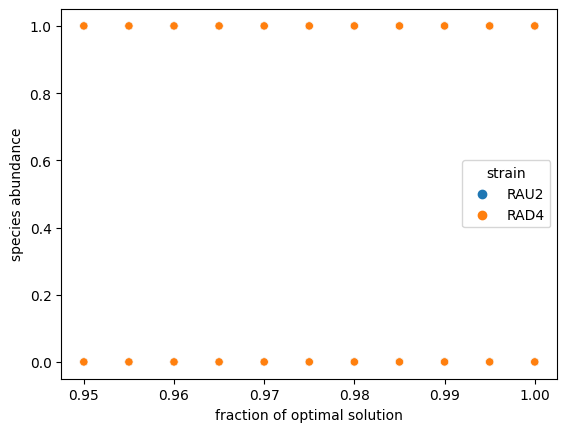

In [47]:
from functions.plot_results import plot_relative_abundance_coculture

plot_relative_abundance_coculture(results_df, scatter=True)

- The entire solution space is available, this is because there is no CA/SAA/RA production at optimum, and therefore the two models are identical

In [48]:
from reframed.community.simulation import simulate as SteadierCom
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadierComFVA(community, constraints=all_constraints, obj_frac=0.95, allocation=True)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

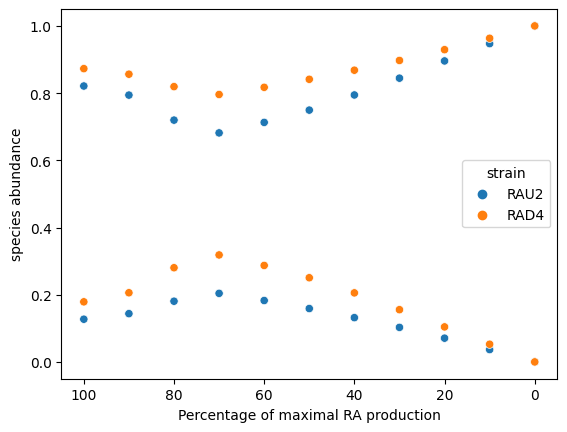

In [49]:
from functions.plot_results import plot_relative_abundance_RA_prod_coculture

#this is for obj_frac = 1.0
plot_relative_abundance_RA_prod_coculture(results_df, scatter=True)

- not particulary interesting

## Model preperation for dfba sim.

calculation on yields 

testing different ways to utilise the data from the static simulation in dfba simulation:

In [16]:
### ----- Here: using the results from steadiercomFVA %RA plot to set lb's that correspond to the RA prodiuction level which seemed to be correct

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

MAM3_lb = (lb_RA / steadiercom_sim.abundance["MAM3"])
SAL11_lb = (lb_RA / steadiercom_sim.abundance["SAL11"])
CAL11_lb = (lb_RA / steadiercom_sim.abundance["CAL11"])

# at the opt solution the lower bounds are then:
print("MAM3 RA lb:", MAM3_lb)
print("SAL11 SAA lb:", SAL11_lb)
print("CAL11 CA lb:", CAL11_lb)

In [27]:
# ------ Here: get yields corresponding to 30% of max RA production

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

RA_yield = steadiercom_sim.values["R_RAt_MAM3"] / steadiercom_sim.values["R_XYLtex_MAM3"]
SAA_yield = steadiercom_sim.values["R_SAAt_SAL11"] / steadiercom_sim.values["R_GLCtex_copy2_SAL11"]
CA_yield = steadiercom_sim.values["R_34DHCINMt_CAL11"] / steadiercom_sim.values["R_XYLtex_CAL11"]

In [65]:
print(CA_yield, SAA_yield, RA_yield)

0.015200000000000002 0.018119992184611907 0.006400000000000001


In [64]:
# for exp. data yields, but magnified

CA_yield = CA_yield * 10
SAA_yield = SAA_yield * 10
RA_yield = RA_yield * 10 

In [66]:
### add yield constraints to the models being used for dfba simulation, can use the exp. data, or the calculations from static sim
### before running: set CA_yield, SAA_yield, and RA_yield to correct levels

from cobra.io import read_sbml_model
from functions.modify_GEM import add_ratio_constraint_cobra

# ----- read cobrapy models -----

RAU2_cobra = read_sbml_model("GEMs/RAU2.xml")
RAD4_cobra = read_sbml_model("GEMs/RAD4.xml")

# ----- add yield ratio constraint -----

# knock out GLCtex_copy1 in both models, just so I have one less thing to worry about...
RAU2_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)
RAD4_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)

add_ratio_constraint_cobra(RAU2_cobra, "34DHCINMt", "GLCtex_copy2", CA_yield);
add_ratio_constraint_cobra(RAD4_cobra, "SAAt", "GLCtex_copy2", SAA_yield);
add_ratio_constraint_cobra(RAD4_cobra, "RAt", "GLCtex_copy2", RA_yield);

### dFBA parameters
Set as arguments to dfba_comets.py functions, or hard-coded in the dfba_comets.py functions.
This is list of parameters that were set according to the experimental conditions, all all other params are default:

- medium
    - initial glucose amount
        - 5 g/L glucose in 0.1 L gives $\frac{5 g/L * 1000 * 0.1 L}{180.156 g/mol}$ = 2.78 mmol glucose
    - amino-acids
        -in the experiment yeast-extract is added, so it is difficult to know exact AA amounts
    - tyr__L_e added in small concentration so that growth is possible for tyrB_KO strains
    - phe__L_e added in small concentration so that growth is possible for pheA_KO strains
- inocculum
    - using a base-initial pop of 2.e-3 since this seems to correspond best with exp. measurement
    - scaling each 
- running for 480 cycles, with timestep 0.1 h, corresponding to 48 hours
- dilution rate, refresh rate
    - = 0, since there is no addition of medium
- kinetic parameters
    - Km and Vmax for glucose and xylose uptake in *E. coli* are taken from the paper: [Dynamic flux balance modeling of microbial co-cultures for efficient batch fermentation of glucose and xylose mixtures](https://doi.org/10.1002/bit.22954)
- spaceWidth
    - grid size = 4.65 for a single cell that rooms 100 ml

## Dynamic simulation

running simulation with COMETS

In [67]:
from functions.dfba_comets import simulate_coculture

sim = simulate_coculture(RAU2_cobra, RAD4_cobra, initial_pop=2.e-3)


Running COMETS simulation ...
Done!


### Total biomass

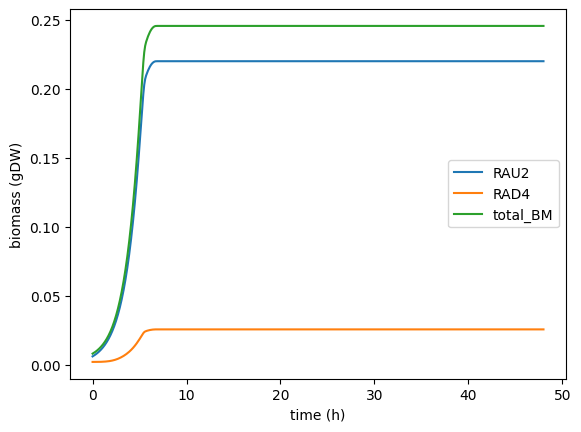

In [68]:
from functions.plot_results import plot_biomass_time_course_coculture

plot_biomass_time_course_coculture(sim.total_biomass)

### Relative species abundance time-course
fig. 7 a

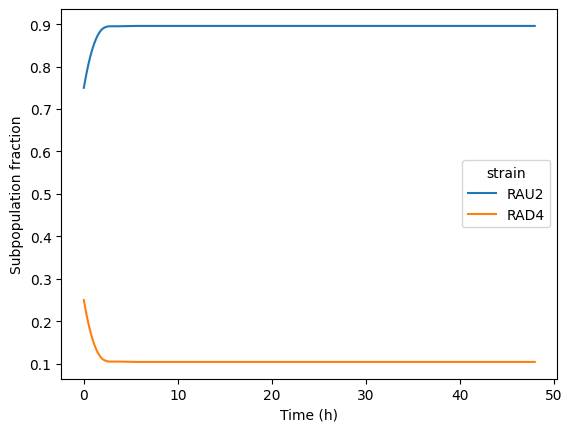

In [69]:
from functions.plot_results import plot_relative_abundance_time_course_coculture

plot_relative_abundance_time_course_coculture(sim.total_biomass)

### Production of CA, SAA, RA
fig 7. b

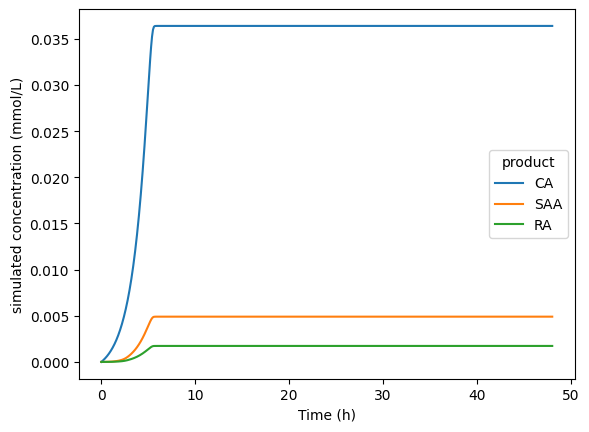

In [70]:
from functions.plot_results import plot_production_time_course

plot_production_time_course(sim.get_metabolite_time_series())

In [71]:
print("Total biomass g(DW):", sum(sim.total_biomass.drop(columns=["cycle"], inplace=False).iloc[-1]))
print("Total RA produced (mmol): ", sim.get_metabolite_time_series()["rosma_e"].iloc[-1])

Total biomass g(DW): 0.24554869121700001
Total RA produced (mmol):  0.0017322434763


### Fluxes

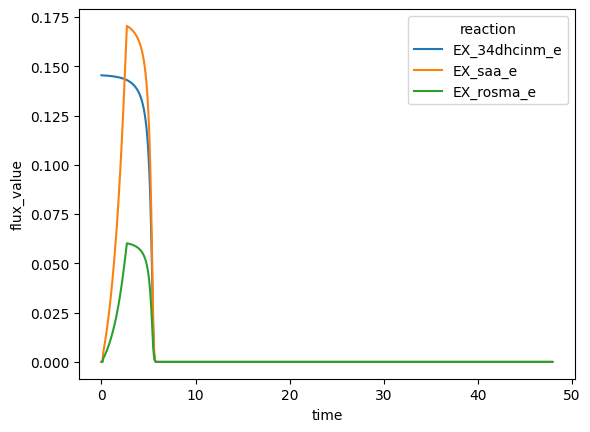

In [72]:
from functions.plot_results import plot_production_flux_values_coculture

plot_production_flux_values_coculture(sim)

### Metabolites

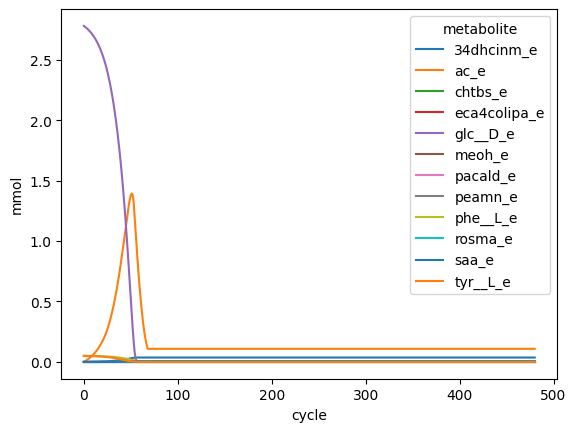

In [73]:
from functions.plot_results import plot_metabolites

plot_metabolites(sim)

### Inoculation ratio
load results from the pairwise comparison (run the program from terminal)

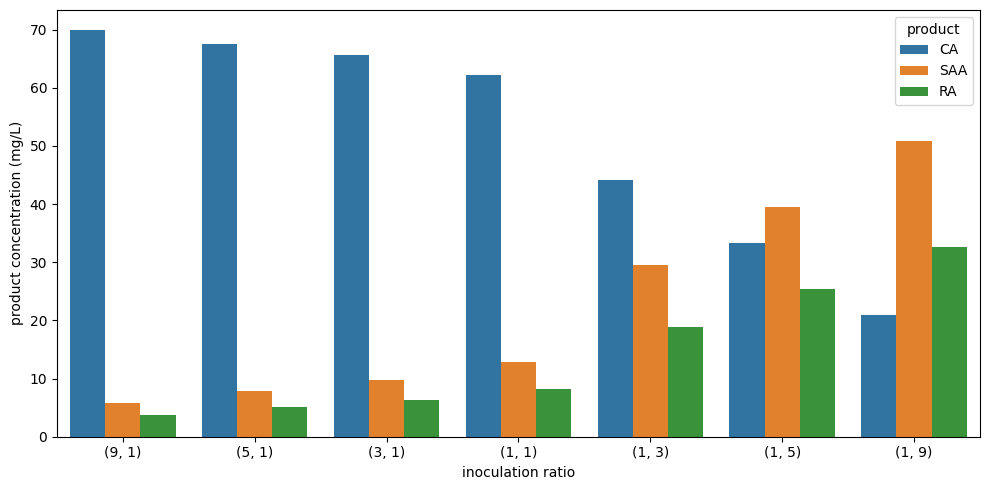

In [112]:
from functions.plot_results import plot_inoculum_3D, get_best_performing_combo
import pandas as pd

result_filepath = "results/fig_3D"

inoculum_results = pd.read_csv(result_filepath)

plot_inoculum_3D(inoculum_results)

In [113]:
get_best_performing_combo(inoculum_results)

The highest RA production with the combination:
 inoculation_ratio       (1, 9)
total_biomass         0.256047
total_RA              0.009077
total_CA              0.011621
total_SAA             0.025699
RA_concentration     32.706032
Name: 6, dtype: object
